<a href="https://colab.research.google.com/github/pgarg7/GOES-Subset/blob/main/GOES_Cloud_v020122.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction to the Notebook**
This notebook illustrats the usage of [goes2go](https://blaylockbk.github.io/goes2go/_build/html/user_guide/index.html) package developed by Dr. Brian Blaylock (University of Utah) to read, process, and subset a GOES16/17 variable within the region of interest and returns a xarray dataset as the final output. 


In [1]:
!pip install goes2go #Install the required goes2go package 

     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 133 kB 54.5 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
     |████████████████████████████████| 8.4 MB 47.6 MB/s 
     |████████████████████████████████| 144 kB 57.1 MB/s 
     |████████████████████████████████| 94 kB 4.4 MB/s 
     |████████████████████████████████| 271 kB 57.1 MB/s 
     |████████████████████████████████| 138 kB 69.2 MB/s 
  Created wheel for aiobotocore: filename=aiobotocore-2.1.0-py3-none-any.whl size=52068 sha256=c2edf3c5dbb18322e9c3625828a4e85b1698351524bbe7c822e5a60937543789
  Stored in directory: /root/.cache/pip/wheels/b4/49/6f/02f2854cad9345dcfb42c86cf20d9519a8d777233282f2bd41
Successfully built aiobotocore
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packa

In [5]:
#Needed to load basic python packages in the environment 
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


# The following cell contains the function which calulcates latitude and longitudes for the given GOES imagery using basic trigonometric functions and geometrical frameworks. 

In [6]:
def calc_latlon(ds,var):
  """
  Input Arguments: 
  ds: xarray dataset from goes2go operation
  var: the desired variable to use. For example: "HT" or cloud top height in this case.

  Output: xarray dataset with lat-lon coordinated added to the dataset object. 

  The math for this function was taken from 
  https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
  """

  x = ds.x                                                                                          #x coordinate of GOES dataset
  y = ds.y                                                                                          #y coordinate of GOES dataset
  t = ds.t                                                                                          #time coordinate of GOES dataset
  goes_imager_projection = ds.goes_imager_projection                                                #Fetch Projection information from GOES file
  
  y,t,x = np.meshgrid(y,t,x)                                                                        #Create a 3-dimensional matrix for each coordinate
  ht = ds[var]                                                                                      #Fetch the desired variable from the dataset
  r_eq = goes_imager_projection.attrs["semi_major_axis"]                                            #Fetch Semi Major Axis of GOES Projection; Radius of Earth at equator 
  r_pol = goes_imager_projection.attrs["semi_minor_axis"]                                           #Fetch Semi Minor Axis of GOES Projection; Radius of Earth at Pole
  l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)                #Fetch Central longitude of GOEs Projection origin 
  h_sat = goes_imager_projection.attrs["perspective_point_height"]                                  #Fetch the GOES perspective point height in the projection plane 
  H = r_eq + h_sat                                                                                  #Calculate the net height of the image projection; Distance of satellite from earth's center
  
  a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))          #Calculate the three variables of quadratic equation to convert the coordinate system
  b = -2 * H * np.cos(x) * np.cos(y)
  c = H**2 - r_eq**2
  
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)                                                          #Solution to the quadratic equation solving the coordinate problem
  
  s_x = r_s * np.cos(x) * np.cos(y)                                                                 #Coordinates of each point rotation calculated using satellite location and Earth's geometry
  s_y = -r_s * np.sin(x)
  s_z = r_s * np.cos(x) * np.sin(y)
  
  lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)         #Calculate latitude for each point
  lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)                                              #Calculate longitude for each point  
  lat[np.isnan(ht)] = 57                                                                            #Fill the missing values with the latitude outside the range
  lon[np.isnan(ht)] = -152                                                                          #Fill the missing values with the longitude outside the range. This is done to easily plot the image. 
  
  ds = ds.assign_coords({                                                                           #Assign coordinates of lat and lon to the dataset
      "lat":(["t","y","x"],lat),
      "lon":(["t","y","x"],lon)
  })
  ds.lat.attrs["units"] = "degrees_north"                                                           #Assign units to each coordinate of lat and lon
  ds.lon.attrs["units"] = "degrees_east"
  return ds

# The follwoing cell provides the x and y indices corresponding to a given lat-lon range specified by the user. 

In [7]:
def get_xy_from_latlon(ds, lats, lons):
  """
  Input Arguments:
  ds: xarray dataset after adding lat-lon coordinates from the previous cell.
  lats: desired latitude range; lat1,lat2
  lons: desired longitude rangel lon1,lon2
  This function returns a subset xarray dataset after performing the desired operation. 

  Output: Indices for GOES x and y coordinates corresponding to the desired lat-lon box. 
  """
  lat1, lat2 = lats                                                                               #Get the upper and lower limit of latitude and longitude box
  lon1, lon2 = lons

  lat = ds.lat.data                                                                               #Obtain the latitude and longitude data from the dataset
  lon = ds.lon.data
  
  x = ds.x.data                                                                                   #x, y and t-cooridnate of the image
  y = ds.y.data                                                                     
  t = ds.t.data
  #print(x.shape,lat.shape)
  
  y,t,x = np.meshgrid(y,t,x)                                                                      #Create a 3D matrix of coordinates to perform subset operation
  
  x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]                            #Subset on x and y using the lat and lon box
  y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
  
  return ((min(x), max(x)), (min(y), max(y)))                                                     #Returns the min and max indices corresponding to x and y coordinates in the dataset

In [8]:
def get_data(product,start_time,end_time,var,lons,lats,filename):
  """ 
  Input Arguments:
  product: GOES product acronym: For example: ABI-L2-ACHAC in this case
  start_time: Desired start time of the GOES period
  end_time: Desired end time of the GOES period
  var: Desired variable: "HT" or cloud top height in this example
  lons: desired longitude range; lon1,lon2
  lats: desired latitude range: lat1, lat2
  filename: Desired filename to save the netcdf file in the memory 

  Output: Subset xarray dataset saved in the local disk. Add path before {filename}.nc in Line 36 if running on local system or if you wish to save it on google drive. 
  For example: /Desktop/work/goes/{filename}.nc

  """

  from datetime import datetime, timedelta                                                       # Load the required libraries
  from goes2go.data import goes_timerange
  

  start = start_time                                                                             # Start and end time of the desired timerange of GOES data
  end = end_time

  g = goes_timerange(start, end,                                                                 # Perform the operation using goes2go timerange module to find all the files in the range and merge
                    satellite='goes16',                                                          # in a xarray dataset
                    product=product,
                    return_as='xarray')
  
  ds = calc_latlon(g,var)                                                                        # Call the calc_latlon function to add lat-lon coordinates to the dataset
  
  lats = lats                                                                                    # Fetch the latitude and longitude of the desired subset box 
  lons = lons

  ((x1,x2), (y1, y2)) = get_xy_from_latlon(ds, lats, lons)                                       # Fetch the x and y indices of the lat-lon box 

  subset = ds.sel(x=slice(x1, x2), y=slice(y2, y1))                                              # Slice the xarray dataset to obtain values in the desired lat-lon box

  subset.to_netcdf('{filename}.nc'.format(filename=filename),format='NETCDF4')                   # Save the subset file with all timesteps in the memory as a NETCDF4 file

  return subset


In [9]:
start = datetime.datetime(2019, 12, 25, 10)                                                      # Start time step 
end = datetime.datetime(2019, 12, 26, 10)                                                        # End Time step
lats = (30.05,39.5)                                                                              # Latitude range (degrees) 
lons = (-78.3,-76.1)                                                                             # Longitude range (degrees)

In [10]:
ds = get_data('ABI-L2-ACHAC',start,end,'HT',lons,lats,'abi_ht_2512201910')                       # Call the function get_data to obtain the final subset of the dataset within the desired lat-lon box.

/usr/local/lib/python3.7/dist-packages/goes2go/__init__.py:15: UserWarning: goes2go xarray accessors could not be imported.
  warnings.warn("goes2go xarray accessors could not be imported.")


⚙ Created config file [/root/.config/goes2go/config.toml] with default values.
 _______________________________
 | Satellite: noaa-goes16      |
 |   Product: ABI-L2-ACHAC     |
 |    Domain: C                |
📦 Finished downloading [288] files to [/root/data/noaa-goes16/ABI-L2-ACHAC].
📚 Finished reading [288] files into xarray.Dataset.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/xarray/conventions.py:449: UserWarning: Variable 't' has datetime type and a bounds variable but t.encoding does not have units specified. The units encodings for 't' and 'time_bounds' will be determined independently and may not be equal, counter to CF-conventions. If this is a concern, specify a units encoding for 't' before writing to a file.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SerializationWarning: saving variable y with floating point data as an integer dtype without any _FillValue to use for NaNs
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SerializationWarning: saving variable x with floating point data as an integer dtype without any _FillValue to use for NaNs


In [13]:
ds                                                                                              # The final subsetted dataset

<xarray.Dataset>
Dimensions:                                 (number_of_LZA_bounds: 2, number_of_SZA_bounds: 2, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 288, x: 22, y: 77)
Coordinates: (12/13)
  * t                                       (t) datetime64[ns] 2019-12-25T10:...
  * y                                       (y) float32 0.1079 ... 0.08666
  * x                                       (x) float32 -0.00854 ... -0.00266
    y_image                                 float32 0.08624
    x_image                                 float32 -0.03136
    local_zenith_angle                      float32 70.0
    ...                                      ...
    dataset_name                            (t) <U73 'OR_ABI-L2-ACHAC-M6_G16_...
    date_created                            (t) <U22 '2019-12-25T10:06:09.6Z'...
    time_coverage_start                     (t) <U22 '2019-12-25T10:01:18.9Z'...
    time_coverage_end                       (t) <U22 '2019-12-25T10:03:56.2Z'...
    lat                                     (t, y, x) float32 39.51 ... 30.14
    lon                                     (t, y, x) float32 -78.72 ... -76.02
Dimensions without coordinates: number_of_LZA_bounds, number_of_SZA_bounds, number_of_image_bounds, number_of_time_bounds
Data variables: (12/24)
    HT                                      (t, y, x) float32 9.602e+03 ... 1...
    DQF                                     (t, y, x) float32 0.0 0.0 ... 0.0
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] ...
    goes_imager_projection                  (t) int32 -2147483647 ... -214748...
    y_image_bounds                          (t, number_of_image_bounds) float32 ...
    x_image_bounds                          (t, number_of_image_bounds) float32 ...
    ...                                      ...
    local_zenith_angle_bounds               (t, number_of_LZA_bounds) float32 ...
    solar_zenith_angle_bounds               (t, number_of_SZA_bounds) float32 ...
    percent_uncorrectable_GRB_errors        (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    percent_uncorrectable_L0_errors         (t) float64 0.0 0.0 0.0 ... 0.0 0.0
    cloud_pixels                            (t) float64 2.169e+06 ... 2.009e+06
    filename                                (t) <U110 'noaa-goes16/ABI-L2-ACH...
Attributes: (12/26)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...                        ...
    processing_level:          National Aeronautics and Space Administration ...
    cdm_data_type:             Image
    timeline_id:               ABI Mode 6
    production_data_source:    Realtime
    id:                        c38fa49d-0050-4720-b00f-845b0e4d2403
    path:                      ['noaa-goes16/ABI-L2-ACHAC/2019/359/10/OR_ABI-...

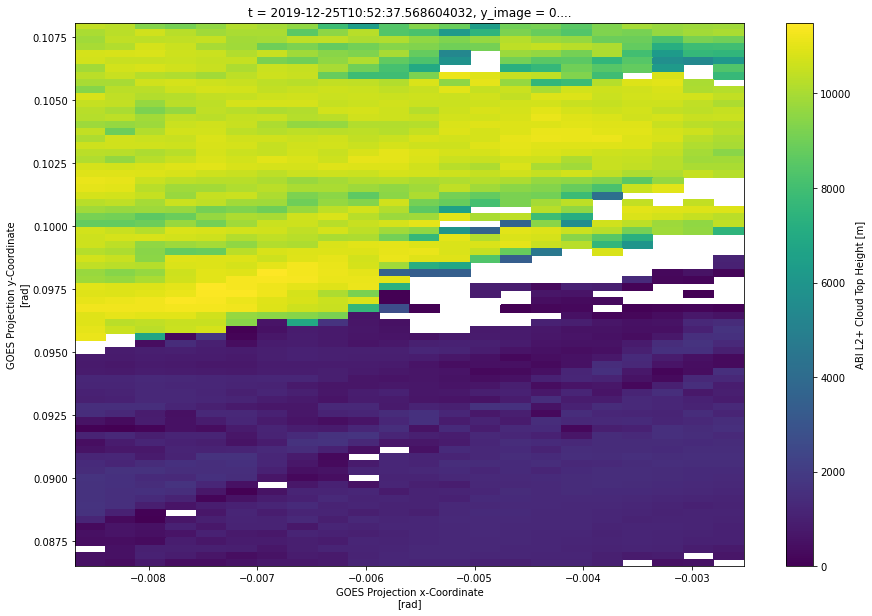

In [18]:
# Plotting the Cloud Top Height in meters
ds.HT.isel(t=10).plot(figsize=(15,10))

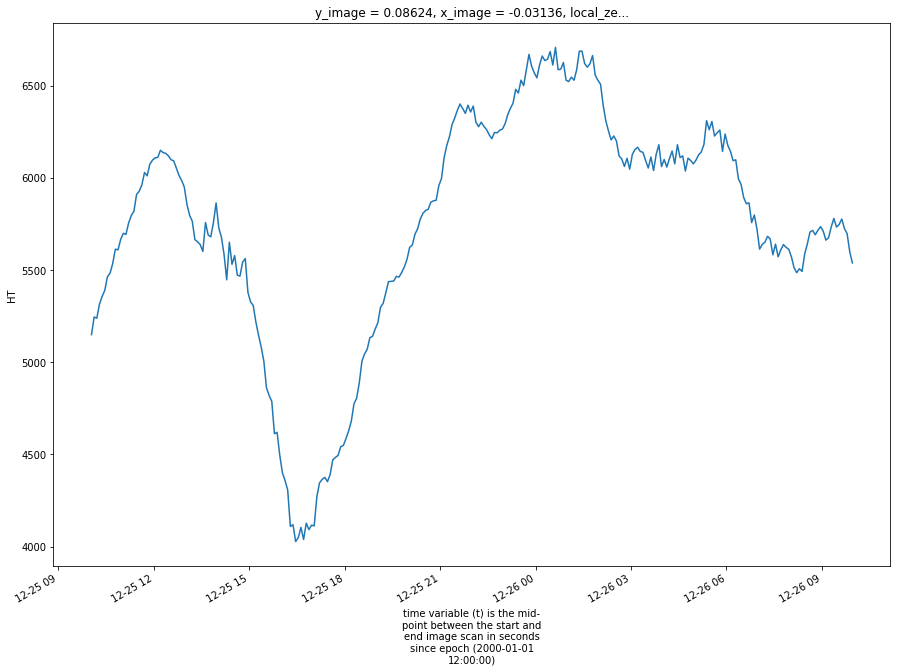

In [16]:
#Plotting the timeseries of mean CTH within the given lat-lon box for the entire time series
ds.HT.mean(axis=(1,2),skipna=True).plot(figsize=(15,10))